In [1]:
!pip install nltk

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense

[nltk_data] Downloading package stopwords to C:\Users\Muhammad Umer
[nltk_data]     Khan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [3]:
def prepare_data():
    try:
        data = pd.read_csv("spam.csv", encoding='latin-1')
    except FileNotFoundError:
        print("Data file not found, make sure it's downloaded.")
        
    data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1, inplace=True)
    data.rename(columns={"v1": "label", "v2": "text"}, inplace=True)
    data.label = data['label'].map({'ham':0, 'spam':1})
    data['Count'] = data['text'].apply(lambda x: len(x))
    
    sw=stopwords.words("english")
    vectorizer = TfidfVectorizer(stop_words=sw, binary=True)

    X = vectorizer.fit_transform(data.text).toarray()
    y = data.label
    
    return X, y

In [4]:
def plot_metrics(history):
    fig = plt.figure(figsize=(10,5))
    for i, metric in enumerate(['accuracy', 'loss']):
        train_metrics = history.history[metric]
        val_metrics = history.history['val_'+metric]
        epochs = range(1, len(train_metrics) + 1)
        plt.subplot(1,2,i+1)
        plt.plot(epochs, train_metrics)
        plt.plot(epochs, val_metrics)
        plt.title('Training and validation '+ metric)
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend(["train_"+metric, 'val_'+metric])


## Overfitting


## L2 Regularization
L2 regularization is perhaps the most common form of regularization analogous to the penalty term in  **Ridge regression**. It penalizes the squared magnitude of the weights $\boldsymbol w$ by adding the term $\frac12 \lambda w^2$ to the objective function that the algorithm is trying to optimize. $\lambda$ is the regularization strength, also called the **shrinkage parameter** which can be tuned during training. 

The regularization term is defined as the Euclidean norm of the weight matrices, which sums over all the squared weights. It is multiplied by $\frac12$ so that when the gradient is calculated we get $\lambda w$.

As the shrinkage parameter approaches infinity, the weights are driven down to near zero but **will not be exactly zero**. 

### Using L2 Regularization in Keras

In Keras, regularization penalties are applied on a per-layer basis, that is, you specify the name of the regularizer API as you add a layer to the network. The `tf.keras.regularizers` module has a built-in L2 class that you can call using the following:


In [8]:
tf.keras.regularizers.l2(l2=0.01)

In [10]:
dense_layer = Dense(32,
    activation='relu',
    kernel_regularizer=tf.keras.regularizers.l2(l2=0.01)
)

## L1 Regularization

L1 regularization is another common form of regularization. It penalizes large weights $\boldsymbol w$ by adding the term $\lambda |w|$ to the objective function, where $\lambda$ is the regularization strength. 

What differentiates L1 from L2 is that, when $\lambda$ approaches infinity, L1 regularization can shrink the weights of the less important features to zero, which would be very useful if you also want automatic feature selection during training. 

<p style='color: blue'>The following figure illustrates how L1 and L2 work differently:</p>

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module1/L3/images/L12_1.png" width="65%"></center>

<p style="text-align:center; color:gray">Source: An Introduction to Statistical Learning</p>


In [11]:
dense_layer = Dense(32,
                       activation='relu', kernel_regularizer=tf.keras.regularizers.l1(l1=0.01))

In [12]:
dense_layer = Dense(32, activation='relu', kernel_regularizer='l1')

## Dropout

During training, Dropout will keep a neuron active with some probability $\boldsymbol p$ (a hyperparameter), or set it to zero otherwise. This regularization technique approximates training a large number of different neural networks in parallel.

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module1/L3/images/DO_1.png" width="60%"></center>

Picture from the [Dropout paper](http://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01)

Dropout can be interpreted as sampling a neural network within the full neural network and only updating the weights of the sampled network. By doing so, each iteration is using a different model architecture and has a different "view" of the configured layers. This adds noise to the training process and perhaps breaks up situations where network layers co-adapt to correct prior mistakes, making the network more robust.

Note that **Dropout is not used during prediction**.


In [13]:
from tensorflow.keras.layers import Dropout

In [14]:
dropout_layer = Dropout(rate=0.2)

## Batch Normalization

Training deep neural networks is complicated, because the distribution of each layer's inputs changes as the weights of the previous layers get updated during back propagation. This can result in the learning algorithm always pursuing a moving target. In the [original paper](https://arxiv.org/abs/1502.03167?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01) of Batch Normalization, the change in the distribution of inputs to layers in the network is referred to as **"internal covariate shift"**. This slows down the training by requiring lower learning rates and careful parameter initialization, making it hard for the model to generalize well. Sometimes, if the training samples are statistically too different from the testing samples, it is considered a covariate shift.


### What is Batch Normalization?

Batch normalization is a technique for training very deep neural networks that normalizes the inputs to a layer for every mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

**Batch**, or **mini-batch**, is a collection of samples that will be passed through the network at one time for the weights update. **Normalization** is the process of transforming the data to have a mean 0 and a standard deviation 1 (thus follows the standard normal distribution). 

In a neural network, batch normalization is achieved through a normalization layer between the fully connected Dense layers, which fixes the means and variances of each layer's inputs. This way, there is not much change in the distribution of each layer input, and the layers in the network can learn from back-propagation simultaneously without having to wait for the previous layers to learn. This accelerates the training process.

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module1/L3/images/BN_6.png" width="70%"></center>

Image credits to [Ilango Rajagopal](https://medium.com/@ilango100/batch-normalization-speed-up-neural-network-training-245e39a62f85)


### Using Batch Normalization in Keras

In Keras, you can add a Batch Norm layer between the Dense layers by calling `BatchNormalization()` from **keras.layers**. Here is a code example:


In [15]:
from tensorflow.keras.layers import Dense, BatchNormalization
batchnorm_layer = BatchNormalization()

## Example 1: Apply regularization techniques on simulated data

In this example, we will use the **generate_data** function to simulate a degree-3 polynomial dataset with some random noise. We will intentionally overfit the data by creating polynomial features of the data, and then we will observe whether the four regularization techniques can mitigate overfitting in this case.


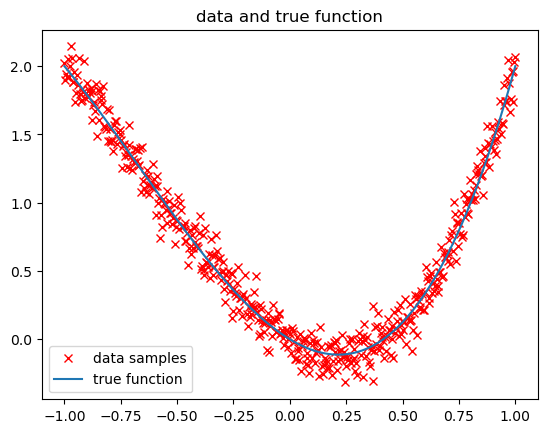

In [16]:
def generate_data(seed=43,std=0.1,samples=500):
    np.random.seed(seed)
    X =np.linspace(-1,1,samples)
    f = X**3 +2*X**2 -X 
    y=f+np.random.randn(samples)*std
    
    return X, y


X,y = generate_data()
f = X**3 +2*X**2 -X
plt.plot(X, y,'rx',label="data samples")
plt.plot(X, f,label="true function")
plt.title("data and true function")
plt.legend()
plt.show()

let's also add some outliers to y:


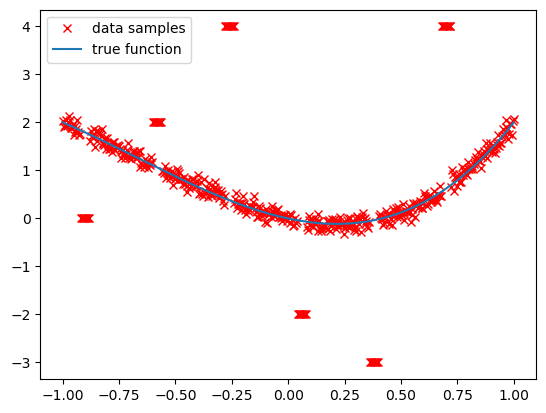

In [17]:
y[20:30] = 0
y[100:110] = 2
y[180:190] = 4
y[260:270] = -2
y[340:350] = -3
y[420:430] = 4

plt.plot(X, y,'rx',label="data samples")
plt.plot(X, f,label="true function")
plt.legend()
plt.show()

In [18]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [23]:
model = Sequential()
model.add(Dense(1000, activation='relu',input_shape=(1,)))
model.add(Dense(120,activation='relu'))
model.add(Dense(120,activation='relu'))
model.add(Dense(1))

In [24]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='mean_squared_error')
model.fit(X, y, epochs=20, batch_size = 100)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 1.6466
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1430
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8535
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1459
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.8157
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7717
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7164
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8268
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.8524
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7670
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8338
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7370
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6766
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7770
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7692
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


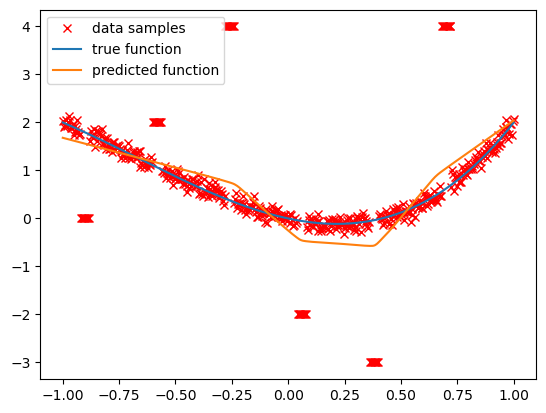

In [25]:
y_pred = model.predict(X)
plt.plot(X, y,'rx',label="data samples")
plt.plot(X, f,label="true function")
plt.plot(X, y_pred ,label="predicted function")
plt.legend()
plt.show()

In [26]:
no_reg = np.mean((y-y_pred)**2)
print(f"Mean squared error is {no_reg}\n")

Mean squared error is 1.9251475190538354



### L1 (Lasso)


In [27]:
model_l1 = Sequential()
model_l1.add(Dense(1000, activation='relu', input_shape=(1,), kernel_regularizer=tf.keras.regularizers.l1(l1=0.01)))
model_l1.add(Dense(120, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(l1=0.01)))
model_l1.add(Dense(120, activation='relu'))
model_l1.add(Dense(1))
model_l1.compile(optimizer=Adam(learning_rate=1e-3), loss='mean_squared_error')
model_l1.fit(X, y, epochs=20, batch_size = 100)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 44.8813
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 39.0921
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 33.5888
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 28.6140
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 24.1727
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 20.2664
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 16.6088
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 13.3283
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 10.6860
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8.1939
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 6.2524
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 4.6540
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.2865
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.7950
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.2175
Epoch 16/20
5/5 ━━━━━━━━

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


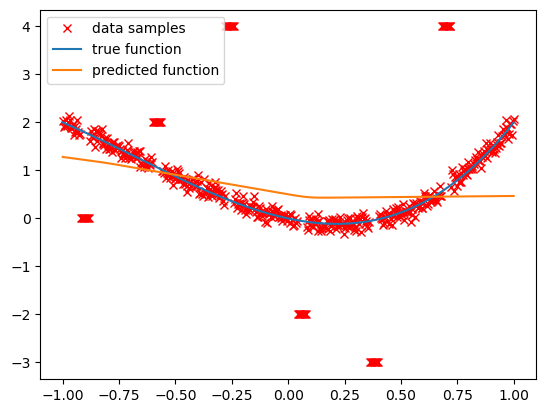

In [28]:
y_pred = model_l1.predict(X)
plt.plot(X, y,'rx',label="data samples")
plt.plot(X, f,label="true function")
plt.plot(X, y_pred,label="predicted function")
plt.legend()
plt.show()

In [29]:
l1 = np.mean((y-y_pred)**2)
print(f"Mean squared error is {l1}\n")

Mean squared error is 1.3748560355354567



### L2 (Ridge)


In [32]:
model_l2 = Sequential()

model_l2.add(Dense(1000, activation='relu',input_shape=(1,),kernel_regularizer=keras.regularizers.l2(l2=0.0001)))
model_l2.add(Dense(120,activation='relu',kernel_regularizer=keras.regularizers.l2(l2=0.0001)))
model_l2.add(Dense(120,activation='relu',kernel_regularizer=keras.regularizers.l2(l2=0.0001)))
model_l2.add(Dense(1))
model_l2.compile(optimizer=Adam(learning_rate=1e-3), loss="mean_squared_error")
model_l2.fit(X, y, validation_split=0.2, epochs=20, batch_size=40)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - loss: 1.2646 - val_loss: 4.7079
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.7914 - val_loss: 5.1247
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.6873 - val_loss: 4.3089
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.8556 - val_loss: 4.3379
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.6702 - val_loss: 3.9792
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.6164 - val_loss: 4.2135
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.7192 - val_loss: 3.5295
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.6357 - val_loss: 3.2992
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.6247 - val_loss: 3.1083
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.6816 - val_loss: 3.0513
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.6301 - val_loss: 2.7873
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


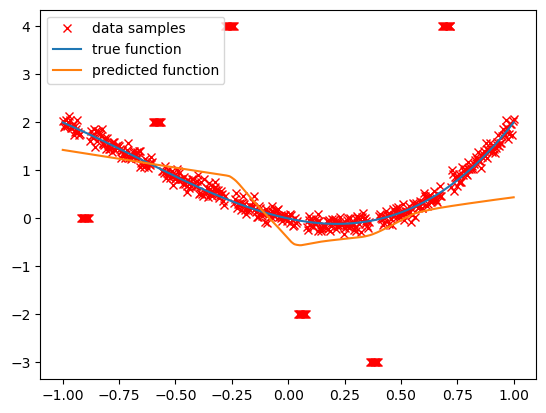

In [33]:
y_pred = model_l2.predict(X)
plt.plot(X, y,'rx',label="data samples")
plt.plot(X, f,label="true function")
plt.plot(X, y_pred ,label="predicted function")
plt.legend()

In [34]:
l2 = np.mean((y-y_pred)**2)
print(f"Mean squared error is {l2}\n")

Mean squared error is 1.7789676062491782



### Dropout


In [36]:
model_dp = Sequential()

model_dp.add(Dense(1000, activation='relu',input_shape=(1,)))
model_dp.add(Dropout(0.1))
model_dp.add(Dense(120,activation='relu'))
model_dp.add(Dropout(0.1))
model_dp.add(Dense(120,activation='relu'))
model_dp.add(Dropout(0.1))
model_dp.add(Dense(1))
model_dp.compile(optimizer=Adam(learning_rate=1e-3), loss="mean_squared_error")
model_dp.fit(X, y, validation_split=0.2, epochs=20, batch_size=40)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 502ms/step - loss: 1.4391 - val_loss: 3.7776
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.6193 - val_loss: 4.7943
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.5982 - val_loss: 5.0442
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.6800 - val_loss: 4.5868
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.6770 - val_loss: 4.3492
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.7851 - val_loss: 4.3169
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.6339 - val_loss: 3.7975
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.6836 - val_loss: 3.8062
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.6206 - val_loss: 3.4673
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.5598 - val_loss: 3.5172
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.7254 - val_loss: 3.1068
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step


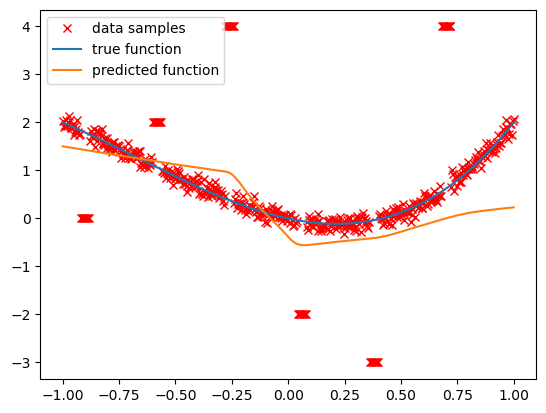

In [37]:
y_pred = model_dp.predict(X)
plt.plot(X, y,'rx',label="data samples")
plt.plot(X, f,label="true function")
plt.plot(X, y_pred ,label="predicted function")
plt.legend()

In [38]:
dp = np.mean((y-y_pred)**2)
print(f"Mean squared error is {dp}\n")

Mean squared error is 1.9014729987956105



### Batch Norm


In [39]:
model_bn = Sequential()

model_bn.add(Dense(1000, activation='relu',input_shape=(1,)))
model_bn.add(BatchNormalization())
model_bn.add(Dense(120,activation='relu'))

model_bn.add(Dense(120,activation='relu'))
model_bn.add(Dense(1))
model_bn.compile(optimizer=Adam(learning_rate=1e-3), loss="mean_squared_error")
model_bn.fit(X, y, validation_split=0.2, epochs=20, batch_size=40)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 187ms/step - loss: 1.2088 - val_loss: 2.7200
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.7323 - val_loss: 2.6545
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.8064 - val_loss: 2.7375
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - loss: 0.6184 - val_loss: 2.7629
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - loss: 0.5022 - val_loss: 2.7417
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.6858 - val_loss: 2.7067
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.5441 - val_loss: 2.7841
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.8423 - val_loss: 2.8245
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.0071 - val_loss: 2.7482
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.7650 - val_loss: 2.6128
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.5888 - val_loss: 2.8824
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss:

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step


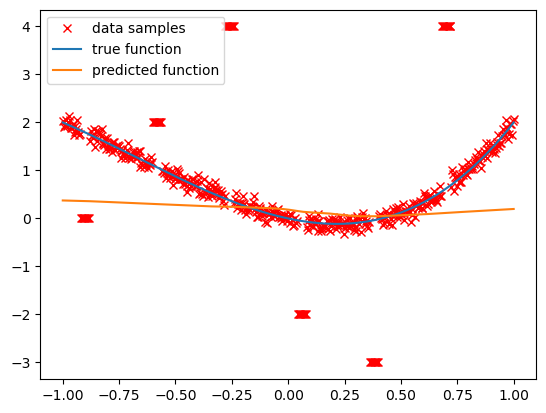

In [40]:
y_pred = model_bn.predict(X)
plt.plot(X, y,'rx',label="data samples")
plt.plot(X, f,label="true function")
plt.plot(X, y_pred ,label="predicted function")
plt.legend()

In [41]:
bn = np.mean((y-y_pred)**2)
print(f"Mean squared error is {bn}\n")

Mean squared error is 1.5545931630694836



## Data Shuffling

To apply data shuffling to avoid overfitting, we can simpy call `shuffle=True` when fitting the model.


In [43]:
model_sh = Sequential()

model_sh.add(Dense(1000, activation='relu',input_shape=(1,)))
model_sh.add(Dense(120,activation='relu'))
model_sh.add(Dense(120,activation='relu'))
model_sh.add(Dense(1))

model_sh.compile(optimizer=Adam(learning_rate=1e-3), loss="mean_squared_error")
model_sh.fit(X, y, validation_split=0.2, epochs=20, batch_size=40,shuffle=True)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - loss: 1.1710 - val_loss: 4.3804
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.9143 - val_loss: 5.2989
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.8324 - val_loss: 4.4826
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.5914 - val_loss: 4.0778
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.5850 - val_loss: 4.4964
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.6478 - val_loss: 4.2851
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.6700 - val_loss: 3.9829
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.5608 - val_loss: 3.6552
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.5439 - val_loss: 3.5307
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.5742 - val_loss: 2.9582
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.6148 - val_loss: 2.7531
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step


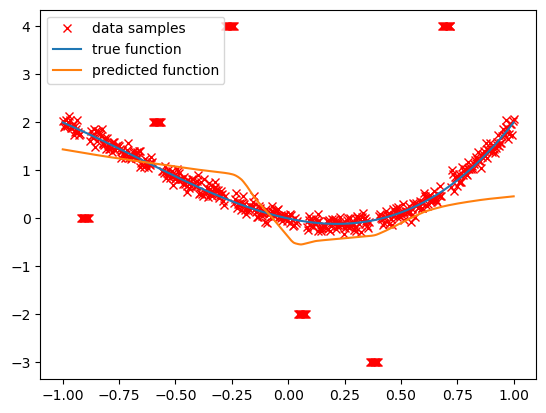

In [44]:
y_pred = model_sh.predict(X)

plt.plot(X, y,'rx',label="data samples")
plt.plot(X, f,label="true function")
plt.plot(X, y_pred ,label="predicted function")
plt.legend()

In [45]:
sh = np.mean((y-y_pred)**2)
print(f"Mean squared error is {sh}\n")

Mean squared error is 1.7761237366535094



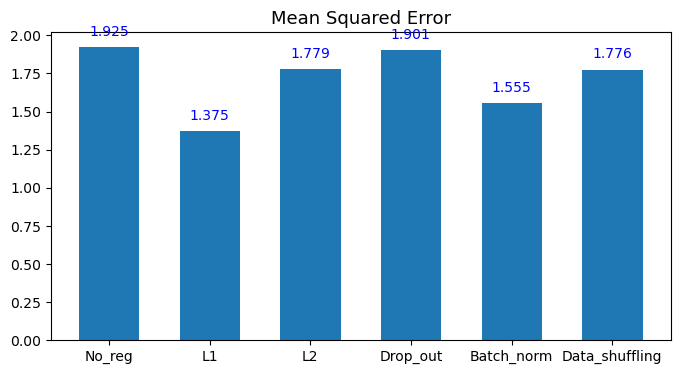

In [46]:
names = ['No_reg','L1','L2','Drop_out','Batch_norm','Data_shuffling']
error = [no_reg, l1, l2, dp, bn, sh]

plt.figure(figsize=(8, 4))
plt.bar(names, error, width=0.6)
plt.title("Mean Squared Error", fontsize=13)

for i, err in enumerate(error):
    plt.text(i-0.2, err+0.1, str(round(err,3)), color='blue', va='center') 

In [48]:
data = pd.read_csv("spam.csv", encoding="latin-1")
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [49]:
X, y = prepare_data()
X.shape, y.shape

((5572, 8536), (5572,))

In [50]:
input_dim = X.shape[1]
   
def get_model(reg=None, epochs=10):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(input_dim,)))
    if reg=="L1":
        model.add(Dense(256, activation='relu', kernel_regularizer="l1"))
        model.add(Dense(64, activation='relu', kernel_regularizer="l1"))
    elif reg=="L2":
        model.add(Dense(256, activation='relu', kernel_regularizer="l2"))
        model.add(Dense(64, activation='relu', kernel_regularizer="l2"))
    elif reg=="Dropout":
        model.add(Dropout(0.2))
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.2))
    elif reg=="BatchNorm":
        model.add(BatchNormalization())
        model.add(Dense(256, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dense(64, activation='relu'))
        model.add(BatchNormalization())  
    else:
        model.add(Dense(256, activation='relu'))
        model.add(Dense(64, activation='relu'))  
 
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss="binary_crossentropy", optimizer="adam",
                 metrics=["accuracy"])
    history = model.fit(X, y, batch_size=64, validation_split=0.2,
              epochs=epochs)
    plot_metrics(history)

## no regularization

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy: 0.8703 - loss: 0.3885 - val_accuracy: 0.9749 - val_loss: 0.1263
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 204ms/step - accuracy: 0.9933 - loss: 0.0764 - val_accuracy: 0.9767 - val_loss: 0.0815
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - accuracy: 0.9993 - loss: 0.0033 - val_accuracy: 0.9785 - val_loss: 0.0873
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 198ms/step - accuracy: 1.0000 - loss: 5.3933e-04 - val_accuracy: 0.9758 - val_loss: 0.1038
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - accuracy: 1.0000 - loss: 1.7450e-04 - val_accuracy: 0.9767 - val_loss: 0.1057
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 204ms/step - accuracy: 1.0000 - loss: 9.6807e-05 - val_accuracy: 0.9767 - val_loss: 0.1103
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 192ms/step - accuracy: 1.0000 - loss: 5.8189e-05 - val_accuracy: 0.9767 - val_loss: 0.1137
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 208ms/step - accuracy: 1.0000 - loss: 4

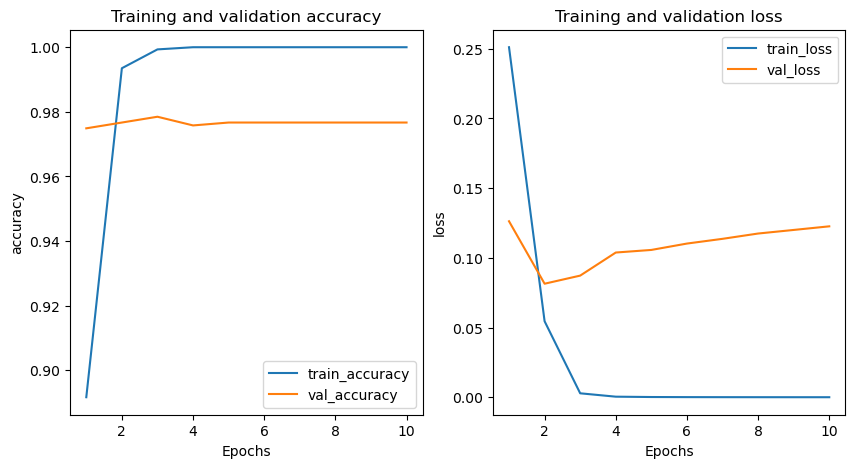

In [59]:
get_model()

## L1

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 25s 226ms/step - accuracy: 0.8198 - loss: 48.5723 - val_accuracy: 0.8700 - val_loss: 6.4297
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 219ms/step - accuracy: 0.8574 - loss: 3.4964 - val_accuracy: 0.8700 - val_loss: 0.6616
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 225ms/step - accuracy: 0.8649 - loss: 0.6192 - val_accuracy: 0.8700 - val_loss: 0.5666
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 231ms/step - accuracy: 0.8525 - loss: 0.5958 - val_accuracy: 0.8700 - val_loss: 0.5627
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 205ms/step - accuracy: 0.8635 - loss: 0.5757 - val_accuracy: 0.8700 - val_loss: 0.5630
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 212ms/step - accuracy: 0.8591 - loss: 0.5837 - val_accuracy: 0.8700 - val_loss: 0.5628
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 202ms/step - accuracy: 0.8694 - loss: 0.5652 - val_accuracy: 0.8700 - val_loss: 0.5627
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 209ms/step - accuracy: 0.8672 - loss: 0.5685 - val_acc

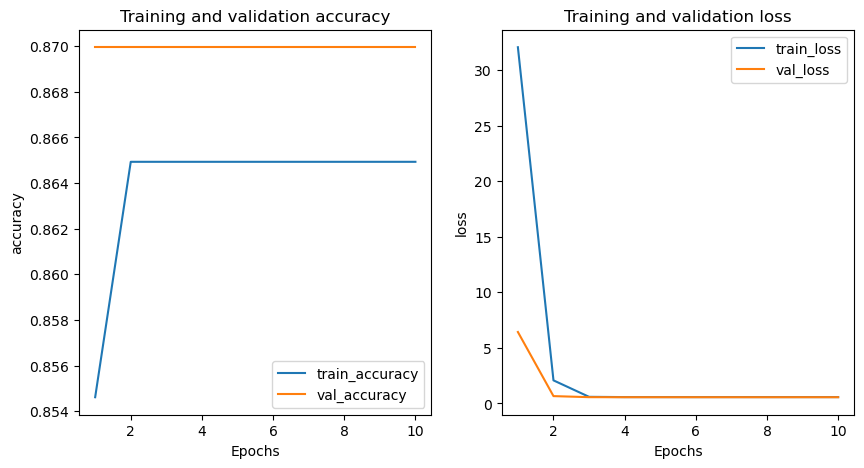

In [52]:
get_model(reg='L1')

## L2

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 213ms/step - accuracy: 0.8416 - loss: 3.2717 - val_accuracy: 0.9453 - val_loss: 0.5456
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 196ms/step - accuracy: 0.9779 - loss: 0.3636 - val_accuracy: 0.9785 - val_loss: 0.1579
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 199ms/step - accuracy: 0.9935 - loss: 0.1079 - val_accuracy: 0.9758 - val_loss: 0.1219
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 199ms/step - accuracy: 0.9995 - loss: 0.0652 - val_accuracy: 0.9821 - val_loss: 0.1016
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - accuracy: 0.9999 - loss: 0.0522 - val_accuracy: 0.9830 - val_loss: 0.0933
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 206ms/step - accuracy: 0.9999 - loss: 0.0433 - val_accuracy: 0.9776 - val_loss: 0.0939
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 202ms/step - accuracy: 0.9995 - loss: 0.0375 - val_accuracy: 0.9821 - val_loss: 0.0834
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 204ms/step - accuracy: 0.9996 - loss: 0.0324 - val_accu

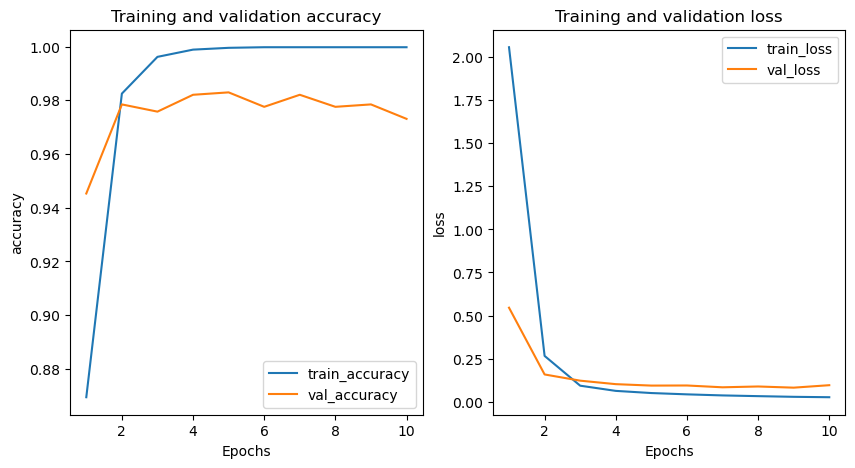

In [56]:
get_model(reg='L2')

## Dropout

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 22s 224ms/step - accuracy: 0.8200 - loss: 0.4324 - val_accuracy: 0.8700 - val_loss: 0.1375
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 208ms/step - accuracy: 0.9728 - loss: 0.0964 - val_accuracy: 0.9803 - val_loss: 0.0637
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - accuracy: 0.9982 - loss: 0.0052 - val_accuracy: 0.9812 - val_loss: 0.0757
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 211ms/step - accuracy: 1.0000 - loss: 6.9026e-04 - val_accuracy: 0.9821 - val_loss: 0.0815
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 197ms/step - accuracy: 1.0000 - loss: 4.1896e-04 - val_accuracy: 0.9767 - val_loss: 0.1084
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 189ms/step - accuracy: 1.0000 - loss: 1.2814e-04 - val_accuracy: 0.9767 - val_loss: 0.1128
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 21s 196ms/step - accuracy: 1.0000 - loss: 8.4585e-05 - val_accuracy: 0.9776 - val_loss: 0.1147
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 194ms/step - accuracy: 1.0000 - loss: 5

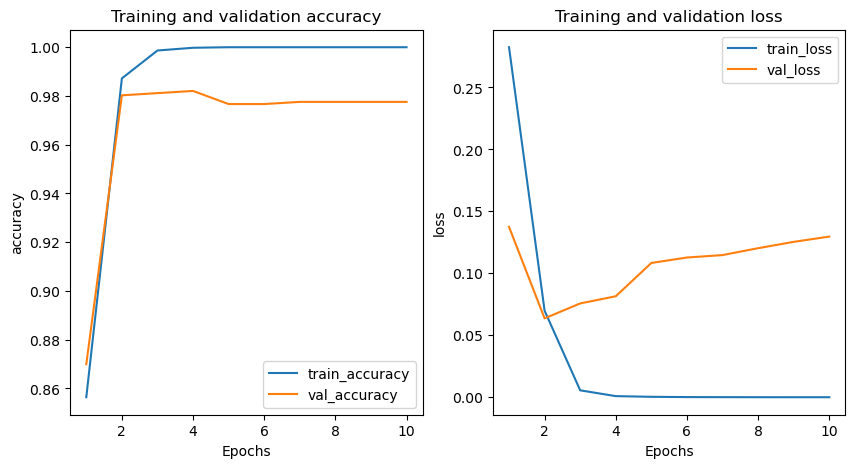

In [57]:
get_model(reg='Dropout')

## Batch Normalization

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 25s 203ms/step - accuracy: 0.7635 - loss: 0.4869 - val_accuracy: 0.8700 - val_loss: 0.3786
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 189ms/step - accuracy: 0.9783 - loss: 0.1010 - val_accuracy: 0.8700 - val_loss: 0.4803
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 193ms/step - accuracy: 0.9945 - loss: 0.0343 - val_accuracy: 0.8700 - val_loss: 0.5986
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 200ms/step - accuracy: 0.9972 - loss: 0.0167 - val_accuracy: 0.8700 - val_loss: 0.6587
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 192ms/step - accuracy: 0.9993 - loss: 0.0097 - val_accuracy: 0.8726 - val_loss: 0.6248
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 199ms/step - accuracy: 0.9994 - loss: 0.0059 - val_accuracy: 0.8915 - val_loss: 0.4533
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 197ms/step - accuracy: 0.9978 - loss: 0.0116 - val_accuracy: 0.9336 - val_loss: 0.3169
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 198ms/step - accuracy: 0.9977 - loss: 0.0093 - val_accu

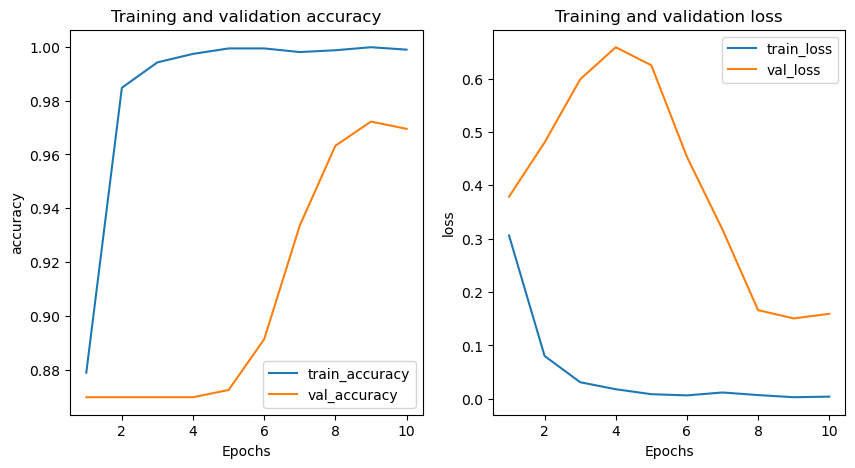

In [58]:
get_model(reg='BatchNorm')